In [1]:
from pyNA.pyna import pyna
import openmdao.api as om
import numpy as np

from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

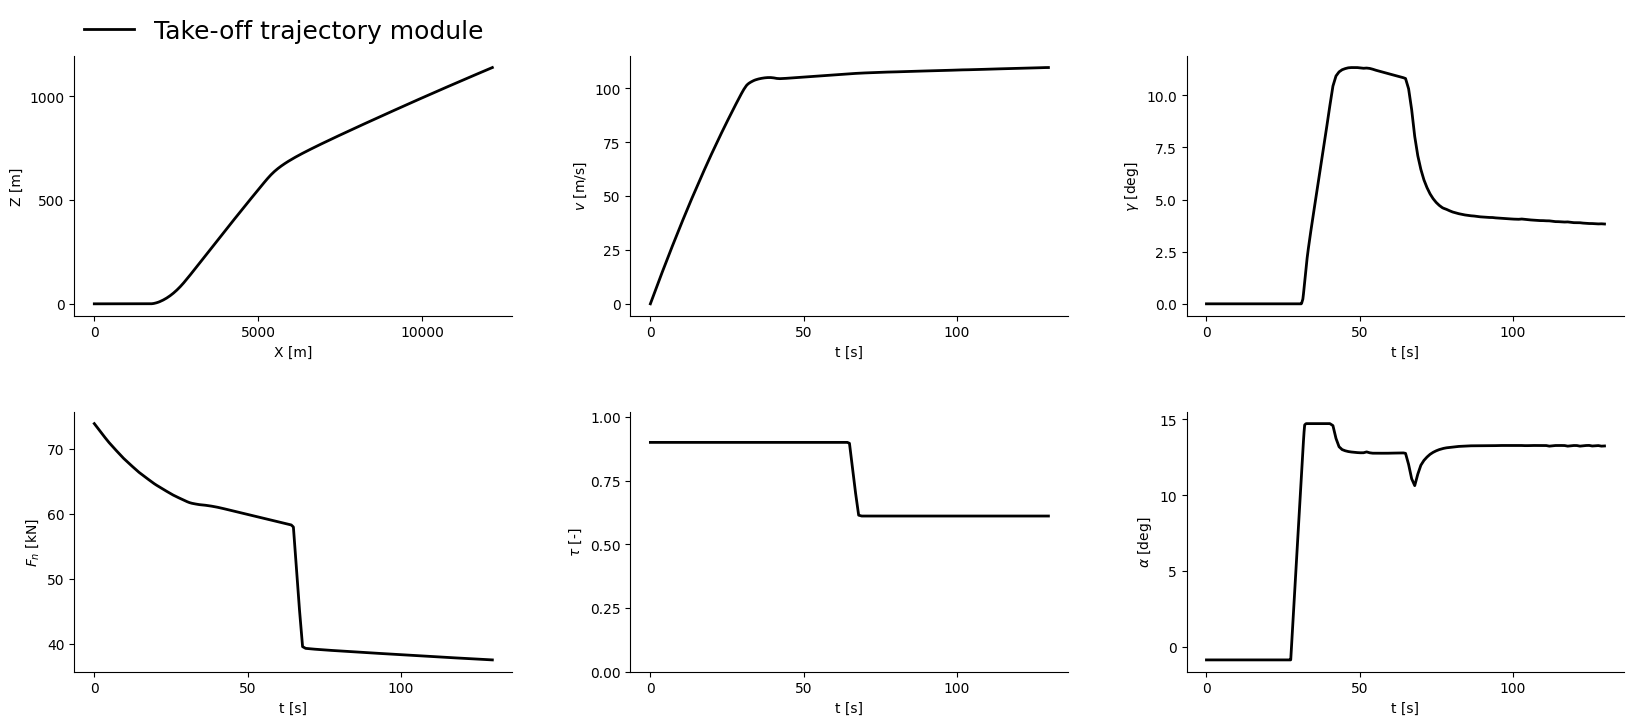

In [2]:
# Get NASA STCA trajectory from file
py_stca = pyna()
py_stca.trajectory.solve(py_stca.settings)
py_stca.plot_trajectory()

In [3]:
# Compute NASA STCA trajectory using take-off model
z_cb = py_stca.trajectory.path.get_val('z')[np.where(py_stca.trajectory.path.get_val('tau') < 0.65)[0][0]]
v_max = py_stca.trajectory.path.get_val('v')[-1]
x_max = py_stca.trajectory.path.get_val('x')[-1]

py = pyna(case_name='stca',
          trajectory_mode='model',
          z_cb=z_cb,
          v_max=v_max,
          x_max=x_max,
          pkrot=True)

# Trajectory controls
tau={'groundroll':0.88, 'rotation':0.88, 'liftoff':0.88, 'vnrs':0.88, 'cutback':0.61}
theta_flaps={'groundroll':10., 'rotation':10., 'liftoff':10., 'vnrs':10., 'cutback':10.}
theta_slats={'groundroll':-6., 'rotation':-6., 'liftoff':-6., 'vnrs':-6., 'cutback':-6.}

py.trajectory.solve(py.settings, py.aircraft, tau=tau, theta_flaps=theta_flaps, theta_slats=theta_slats)

/Users/laurensvoet/Library/Python/3.7/lib/python/site-packages/openmdao/utils/options_dictionary.py:332: OMDeprecationWarning:'gradient method' is not a valid python name and will become an invalid option name in a future release. You can prevent this warning (and future exceptions) by declaring this option using a valid python name.


--- Linkage Report [phases] ---
    --- groundroll - rotation ---
        time               [final] ==  time           [initial]
        states:x           [final] ==  states:x       [initial]
        states:v           [final] ==  states:v       [initial]
        parameters:alpha   [final*] ==  states:alpha   [initial]
    --- rotation - liftoff ---
        time               [final] ==  time             [initial]
        states:x           [final] ==  states:x         [initial]
        parameters:z       [final*] ==  states:z         [initial]
        states:v           [final] ==  states:v         [initial]
        states:alpha       [final] ==  controls:alpha   [initial]
        parameters:gamma   [final*] ==  states:gamma     [initial]
    --- liftoff - vnrs ---
        time             [final] ==  time             [initial]
        states:x         [final] ==  states:x         [initial]
        states:v         [final] ==  states:v         [initial]
        controls:alpha   [fin

/Users/laurensvoet/Library/Python/3.7/lib/python/site-packages/openmdao/recorders/sqlite_recorder.py:224: UserWarning:The existing case recorder file, dymos_solution.db, is being overwritten.


Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been recorded for Driver.
Full total jacobian was computed 3 times, taking 4.881975 seconds.
Total jacobian shape: (247, 169) 


Jacobian shape: (247, 169)  ( 3.91% nonzero)
FWD solves: 11   REV solves: 0
Total colors vs. total size: 11 vs 169  (93.5% improvement)

Sparsity computed using tolerance: 1e-12
Time to compute sparsity: 4.881975 sec.
Time to compute coloring: 0.216257 sec.


Optimization Problem -- Optimization using pyOpt_sparse
    Objective Function: _objfunc

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                   11.2235
       User Objective Time :       0.9180
       User Sensitivity Time :     8.9622
       Interface Time :            1.2075
       Opt Solver Time:            0.1358
    Calls to Objective Function :      28
    Calls to Sens Function :           28


   Objectives
     

Converged: True


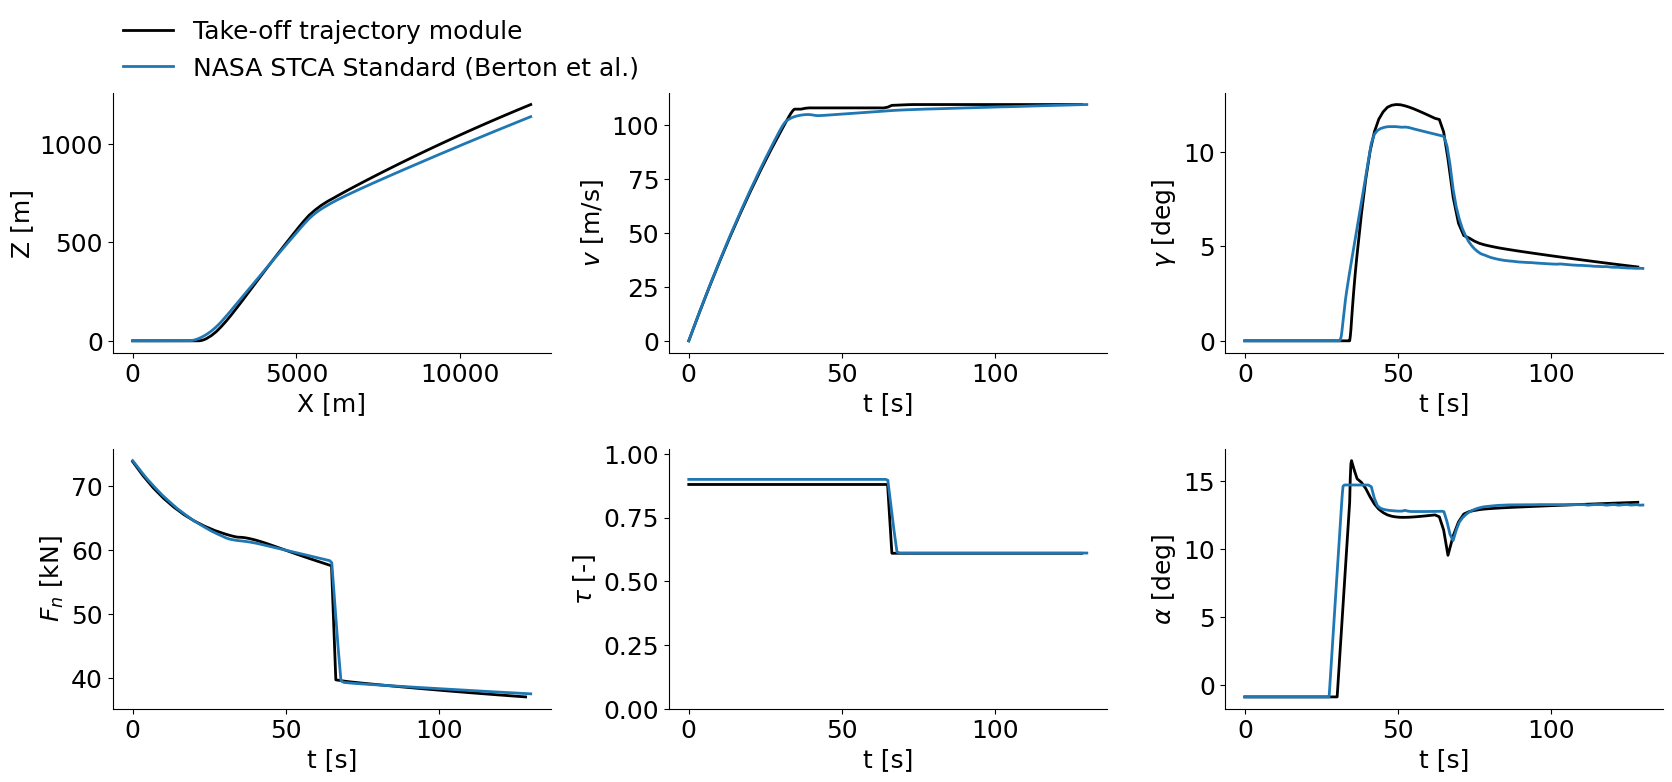

In [4]:
py.plot_trajectory(paths_compare=[py_stca.trajectory.path], labels_compare=['NASA STCA Standard (Berton et al.)'])

In [23]:
# Compute error between the trajectories
t_end_min = np.min((py.trajectory.path.get_val('t_s')[-1], py_stca.trajectory.path.get_val('t_s')[-1]))

n = np.size(py_stca.trajectory.path.get_val('t_s'))
t_ip = np.linspace(0, t_end_min, n)

for i,var in enumerate(['x', 'z', 'v', 'gamma', 'F_n', 'tau', 'alpha']):

    x_ip = np.interp(t_ip, py.trajectory.path.get_val('t_s'), py.trajectory.path.get_val(var)) / np.max(py_stca.trajectory.path.get_val(var))
    x_ip_stca = np.interp(t_ip, py_stca.trajectory.path.get_val('t_s'), py_stca.trajectory.path.get_val(var)) / np.max(py_stca.trajectory.path.get_val(var))
    
    mre = sum(abs(x_ip-x_ip_stca))/n

    self.assertLessEqual(mre, 0.05)

0.005385568990755884
0.025305048761719573
0.013241109678252441
0.03991133226476543
0.005318840983926953
0.01399134094888156
0.034479385119220045


In [18]:
np.sum(abs(x_ip_stca-x_ip))/np.size(x_ip_stca)

0.012592206853993362